In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


open_data = pd.read_csv('open_data_0_gps.csv')
occulded_data = pd.read_csv('occluded_data_0_gps.csv')
straight_line_data = pd.read_csv('straight_line_data_0_gps.csv')

# preprocess data
# remove the last 40 rows of the open data as i didn't turn off the gps until i was back in the house
open_data = open_data[:-40]



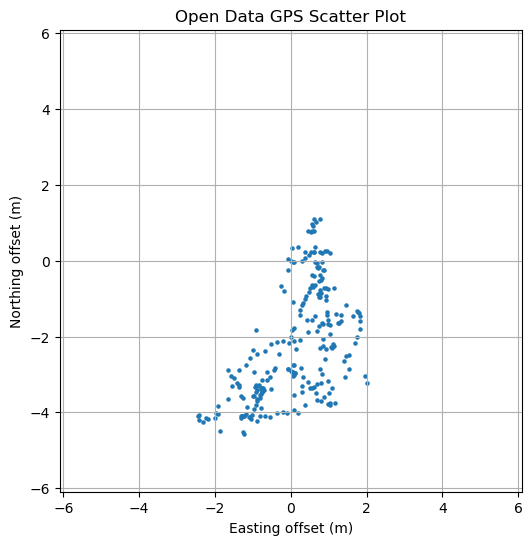

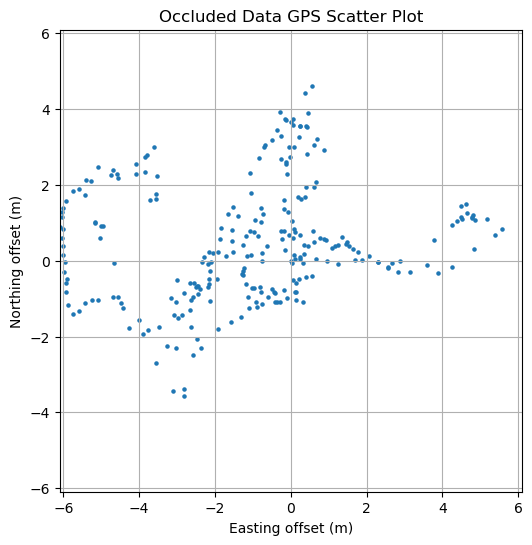

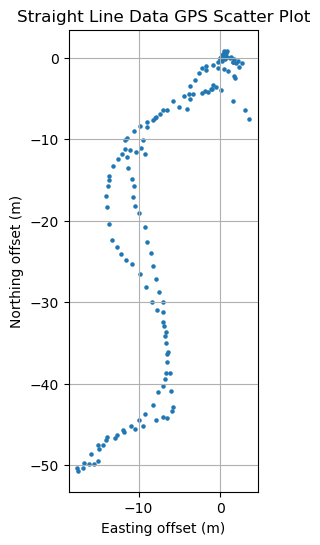

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_gps_scatter(df, title, lims=None):

    e = df['utm_easting'] - df['utm_easting'].iloc[0]
    n = df['utm_northing'] - df['utm_northing'].iloc[0]

    plt.figure(figsize=(6,6))
    plt.scatter(e, n, s=5)

    plt.xlabel('Easting offset (m)')
    plt.ylabel('Northing offset (m)')
    plt.title(title)
    plt.gca().set_aspect('equal')
    plt.grid(True)

    if lims is not None:
        plt.xlim(lims)
        plt.ylim(lims)

    plt.show()


def get_limits(*dfs):
    all_e = []
    all_n = []

    for df in dfs:
        e = df['utm_easting'] - df['utm_easting'].iloc[0]
        n = df['utm_northing'] - df['utm_northing'].iloc[0]
        all_e.extend(e)
        all_n.extend(n)

    m = max(np.max(np.abs(all_e)), np.max(np.abs(all_n)))
    return (-m, m)

lims = get_limits(open_data, occulded_data)

plot_gps_scatter(open_data, 'Open Data GPS Scatter Plot', lims)
plot_gps_scatter(occulded_data, 'Occluded Data GPS Scatter Plot', lims)


plot_gps_scatter(straight_line_data, 'Straight Line Data GPS Scatter Plot')


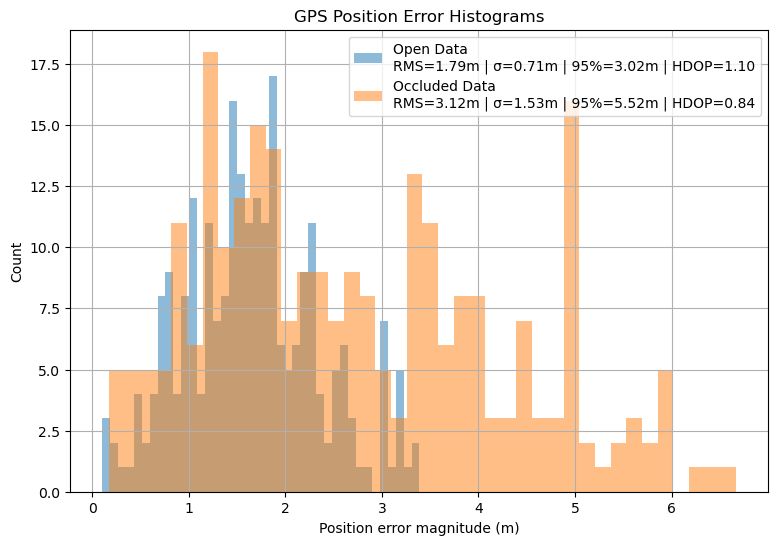

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def plot_error_histograms(datasets, bins=40):
    """
    datasets = list of (df, label) tuples
    """

    plt.figure(figsize=(9,6))

    for df, label in datasets:

        # known position = mean
        E_known = df['utm_easting'].mean()
        N_known = df['utm_northing'].mean()

        dE = df['utm_easting'] - E_known
        dN = df['utm_northing'] - N_known
        error = np.sqrt(dE**2 + dN**2)

        # stats
        rms = np.sqrt((error**2).mean())
        std = error.std()
        p95 = np.percentile(error, 95)
        hdop = df['hdop'].mean()

        legend_label = (
            f"{label}\n"
            f"RMS={rms:.2f}m | σ={std:.2f}m | 95%={p95:.2f}m | HDOP={hdop:.2f}"
        )

        plt.hist(error, bins=bins, alpha=0.5, label=legend_label)

    plt.xlabel("Position error magnitude (m)")
    plt.ylabel("Count")
    plt.title("GPS Position Error Histograms")
    plt.legend()
    plt.grid(True)

    plt.show()

plot_error_histograms([
    (open_data, 'Open Data'),
    (occulded_data, 'Occluded Data'),
])


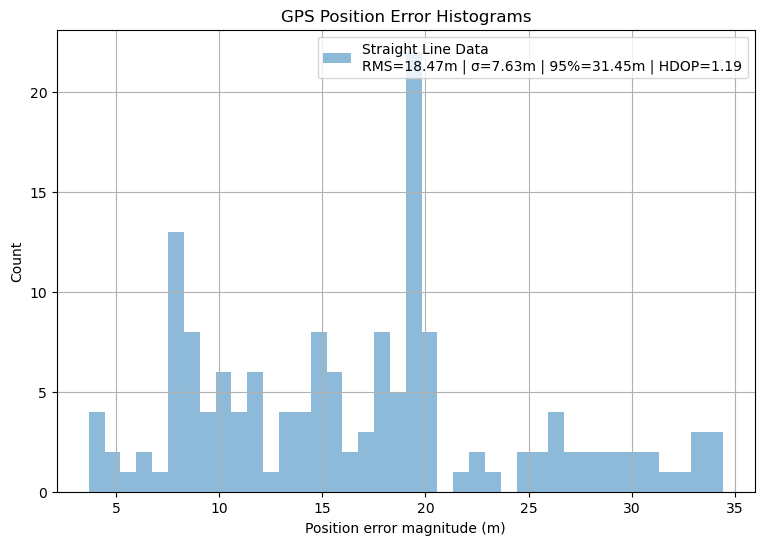

In [35]:
plot_error_histograms([
    (straight_line_data, 'Straight Line Data'),
])

In [50]:
def plot_altitude_vs_time_all(datasets):
    """
    datasets = list of (df, label) tuples
    """

    plt.figure(figsize=(10,5))

    for df, label in datasets:

        t = (df['bag_time_ns'] - df['bag_time_ns'].iloc[0]) / 1e9
        alt = df['altitude']

        plt.scatter(t, alt, label=label, s=5)   # line is nicer than scatter here

    plt.xlabel("Time (s)")
    plt.ylabel("Altitude (m)")
    plt.title("Altitude vs Time Comparison")
    plt.legend()
    plt.grid(True)

    plt.show()


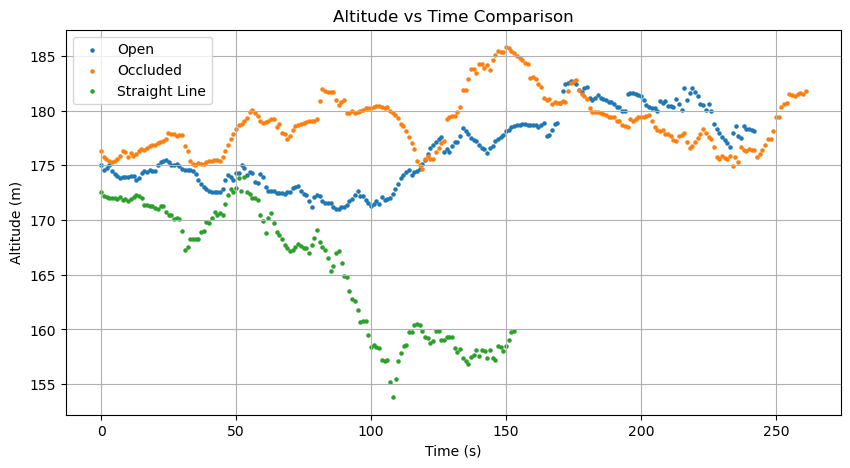

In [64]:
plot_altitude_vs_time_all([
    (open_data, "Open"),
    (occulded_data, "Occluded"),
    (straight_line_data, "Straight Line"),
])


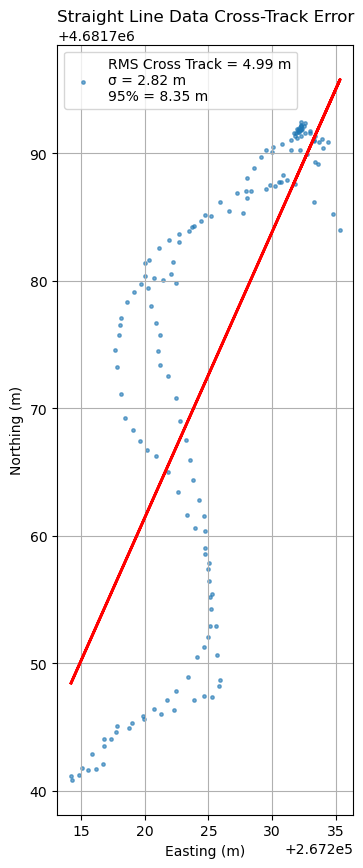

array([ 1.58051914,  1.47399889,  1.52065883,  1.42929061,  1.32517816,
        1.28814932,  1.14219247,  1.09723496,  1.29005856,  1.41629711,
        1.27249876,  1.17536036,  1.1650239 ,  1.23571919,  1.4622517 ,
        1.32878982,  1.34776034,  1.45980151,  1.61464173,  1.19889718,
        1.00798277,  0.77306548,  0.46504514,  0.43474108,  0.02309708,
        0.11857555,  0.05365044,  0.59106716,  1.10108621,  0.45930776,
        0.97078004,  1.10910015,  0.84819575,  0.03302003,  0.61382339,
        1.23131741,  2.06139578,  2.67166657,  2.55069978,  3.09077371,
        3.18164371,  3.30447806,  3.50738964,  3.22120422,  2.85784758,
        2.71737014,  3.73475222,  4.91249637,  5.45182381,  5.75141802,
        5.96059861,  6.56389657,  7.08927634,  7.58435244,  7.95630361,
        8.15178532,  7.68477351,  7.05449369,  6.35422462,  5.44427674,
        4.76422335,  4.3734282 ,  3.737129  ,  2.86254845,  1.5709776 ,
        0.53765492,  0.45814133,  1.3695429 ,  2.25545601,  3.31

In [62]:
import numpy as np
import matplotlib.pyplot as plt

def plot_line_fit_error(df, title):

    E = df['utm_easting'].values
    N = df['utm_northing'].values

    # ---- fit line ----
    m, b = np.polyfit(E, N, 1)
    N_fit = m*E + b

    # ---- perpendicular distance (cross-track error) ----
    error = np.abs(m*E - N + b) / np.sqrt(m**2 + 1)

    # stats
    rms = np.sqrt((error**2).mean())
    std = error.std()
    p95 = np.percentile(error, 95)

    # ---- plot ----
    plt.figure(figsize=(10,10))

    plt.scatter(E, N, s=6, alpha=0.6)

    legend_label = (
        
        f"RMS Cross Track = {rms:.2f} m\n"
        f"σ = {std:.2f} m\n"
        f"95% = {p95:.2f} m"
    )

    plt.plot(E, N_fit, 'r', linewidth=2)

    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")
    plt.title(title)
    plt.legend([legend_label])
    plt.gca().set_aspect('equal')
    plt.grid(True)

    plt.show()

    return error


plot_line_fit_error(straight_line_data, "Straight Line Data Cross-Track Error")

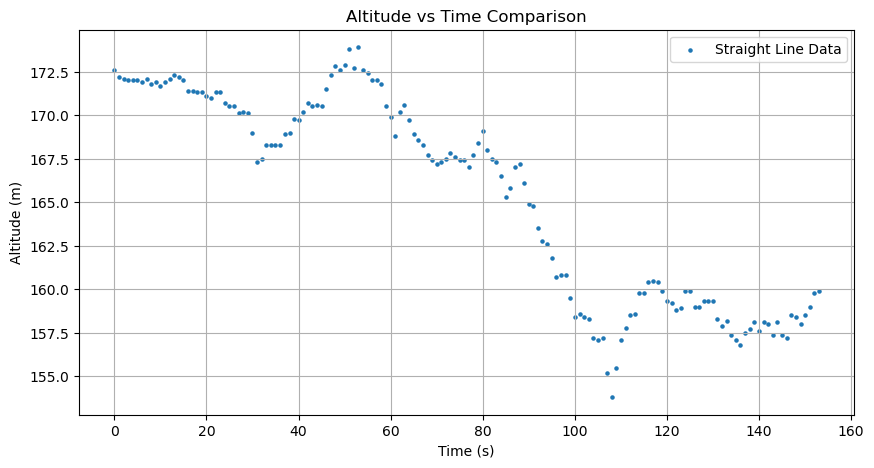

In [63]:
# plot altitude vs time for straight line data
plot_altitude_vs_time_all([
    (straight_line_data, "Straight Line Data"),
])